In [1]:
import numpy as np
import pandas as pd
from h3 import h3

import importlib
import matplotlib.pyplot as plt
%matplotlib inline

import itertools as it
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, date, timedelta
from glob import glob
import sqlite3
import time
from tempfile import TemporaryDirectory

import functools as ft
import tilemapbase as tmb
import folium
from collections import namedtuple
import geojson as gj

import os
import sys
sys.path.append("../")
sys.path.append("../dsutils")

from dsutils import heatmap as hm, gif, timeutil as tu
from colorutil import color_selector_p

/home/uchiumi/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/uchiumi/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/uchiumi/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

In [2]:
!ls -l data

total 960
-rw-rw-rw- 1 uchiumi uchiumi  47432 Apr 27 14:27 heatmap_20200201.csv
-rw-rw-rw- 1 uchiumi uchiumi  47304 Apr 27 16:40 heatmap_20200301.csv
-rw-rw-rw- 1 uchiumi uchiumi  47211 Apr 27 14:27 heatmap_20200401.csv
-rw-rw-rw- 1 uchiumi uchiumi 710965 Apr 27 14:27 ratio.csv


In [3]:
df = pd.read_csv("./data/heatmap_20200401.csv")

In [4]:
df

,h3_10_id,cnt_uuid
0,8a2f5a368ce7fff,256
1,8a2f5a3632e7fff,1
2,8a2f5a34c0f7fff,1
3,8a2f5a36ab57fff,1
4,8a2f5a34c7affff,1
...,...,...
2458,8a2f5a34192ffff,510
2459,8a2f5a345297fff,255
2460,8a2f5a36ead7fff,255
2461,8a2f5a34e887fff,511


In [5]:
print(df["cnt_uuid"].describe())

count    2463.000000
mean       85.342672
std       158.087338
min         1.000000
25%        22.000000
50%        35.000000
75%        80.000000
max      2385.000000
Name: cnt_uuid, dtype: float64


In [6]:
# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
import tilemapbase as tmb
tmb.start_logging()

In [7]:
t = tmb.tiles.build_OSM()
t

In [8]:
ex = hm.extent(df["h3_10_id"])
ex

Extent((0.8877343398788576,0.393609069097437)->(0.8879651497937191,0.39383062539468405) projected as normal)

In [9]:
cs = color_selector_p(df.cnt_uuid, 20)
cs

## Plot

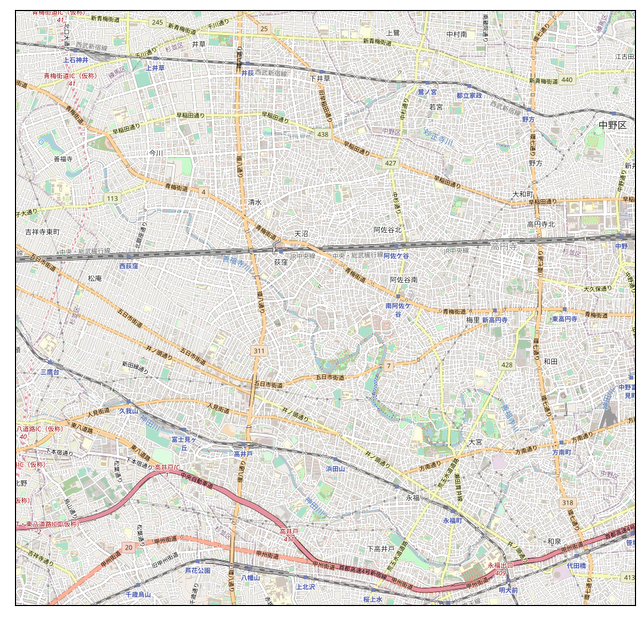

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
    
plotter = tmb.Plotter(ex, t, width=600)
plotter.plot(ax, t)

In [11]:
def _swap(ls):
    return [
        (p[1], p[0])
        for p in ls
    ]

In [12]:
def draw(df, id_col, val_col, extent, color_selector, figsize=(8, 8), dpi=100, width=600, alpha=0.8, axis_visible=False):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.xaxis.set_visible(axis_visible)
    ax.yaxis.set_visible(axis_visible)

    t = tmb.tiles.build_OSM()
    plotter = tmb.Plotter(extent, t, width=width)
    plotter.plot(ax, t)

    n = len(df)
    for i in range(n):
        id = df[id_col].iloc[i]
        val = df[val_col].iloc[i]
        color = "red" # color_selector(val)
        color = color_selector(val)
        vts = _swap(h3.h3_to_geo_boundary(id))
        xys = [tmb.project(*x) for x in vts]
        poly = plt.Polygon(xys, fc=color, alpha=alpha)
        ax.add_patch(poly)

    return fig, ax

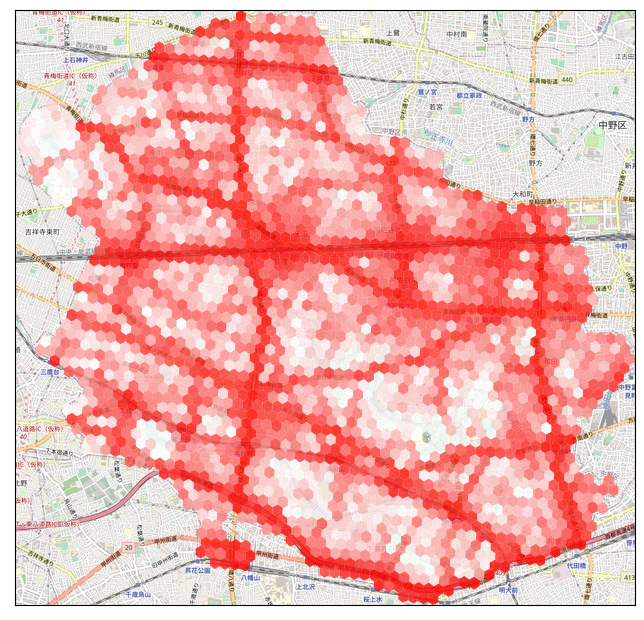

In [13]:
fig, ax = draw(df, "h3_10_id", "cnt_uuid", ex, cs)
fig.show()
fig.savefig("heatmap_suginami_20200401.png")